In [39]:
using LinearAlgebra
using Flux
using DiffEqFlux
using OrdinaryDiffEq
using DiffEqSensitivity
using GalacticOptim
using Plots
using Zygote
using BenchmarkTools
using CUDA
using Printf
using MLUtils
using IterTools: ncycle
using BSON: @save, @load

include("src/equations/initial_functions.jl")
include("src/equations/equations.jl")
include("src/utils/graphic_tools.jl")
include("src/utils/generators.jl")
include("src/neural_ode/objectives.jl")
include("src/neural_ode/models.jl")
include("src/neural_ode/blocks.jl")
include("src/neural_ode/regularization.jl")
include("src/rom/pod.jl")
include("src/utils/processing_tools.jl")

Main.ProcessingTools

# FOM + ROM solutions

Compute some fom and rom solution u(t, x)

## Test various burgers resolution method for FOM

Experiments with different initial conditions: Gaussian random, high dimensional random, sin, exp, -x, etc.

In [2]:
t_max = 1.; # 6 (godunov)
t_min = 0.;
x_max = pi; # 2pi (godunov)
x_min = 0.;
t_n = 64;
x_n = 64;

nu = 0.04;

dt = round((t_max - t_min) / (t_n - 1), digits=8);
dx = round((x_max - x_min) / (x_n - 1), digits=8);

t = LinRange(t_min, t_max, t_n);
x = LinRange(x_min, x_max, x_n);

In [3]:
function animate_snapshot_prediction(u_pred, u, x, filename)
    t_n = 64
   
    anim = @animate for i ∈ 1:t_n
        plt = plot(x, u[:, i], label="u")
        plot!(plt, x, u_pred[:, i], linestyle=:dash, label="û")
        plot!(plt; xlims=(0., pi), ylims=(-2, 2.), dpi=300)
    end

    gif(anim, filename, fps = 15)
end

animate_snapshot_prediction (generic function with 1 method)

### Godunov

In [4]:
function random_init(t, x)
  u = zeros(Float64, size(t, 1), size(x, 1))
  d = Normal(1., .5)
  nu = rand(d, size(x, 1))
  u[1, :] .= sin.(x) #+ nu
  u[:, 1] .= 0
  u[:, end] .= 0

  return u
end

random_init (generic function with 1 method)

In [18]:
u0 = InitialFunctions.high_dim_random_init(t, x, 10);
# u0 = exp.(-16 .* (x.^2));
#u0 = InitialFunctions.advecting_shock(t, x, nu);
# u0 = random_init(t, x);
# u0 = InitialFunctions.random_gaussian_init(t, x, 0.25, 0.25);
# u0 = -1 .* collect(x);

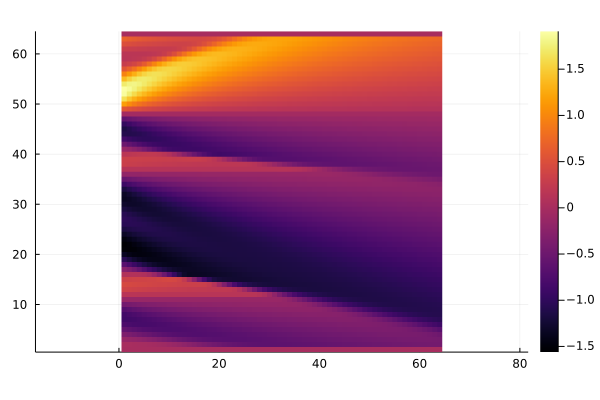

In [23]:
t1, u1 = Equations.get_burgers_godunov(t, dx, x_n, nu, u0[1, :]);
GraphicTools.show_state(u1, "") # need to reverse u, odesolver switch dimensions

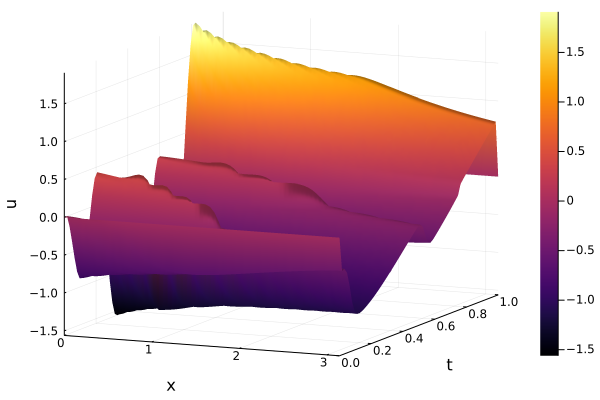

In [20]:
plot(x, t1, u1, st = :surface, xlabel = "x", ylabel = "t", zlabel = "u")
plot!(dpi=300)

┌ Info: Saved animation to 
│   fn = /Users/vdesgrange/Development/Etudes/Thesis/closure-model/experiments/julia_src/neural_closure/snapshot_viscous_burgers_nu004_fps15.gif
└ @ Plots /Users/vdesgrange/.julia/packages/Plots/1KWPG/src/animation.jl:114


Plots.AnimatedGif("/Users/vdesgrange/Development/Etudes/Thesis/closure-model/experiments/julia_src/neural_closure/snapshot_viscous_burgers_nu004_fps15.gif")
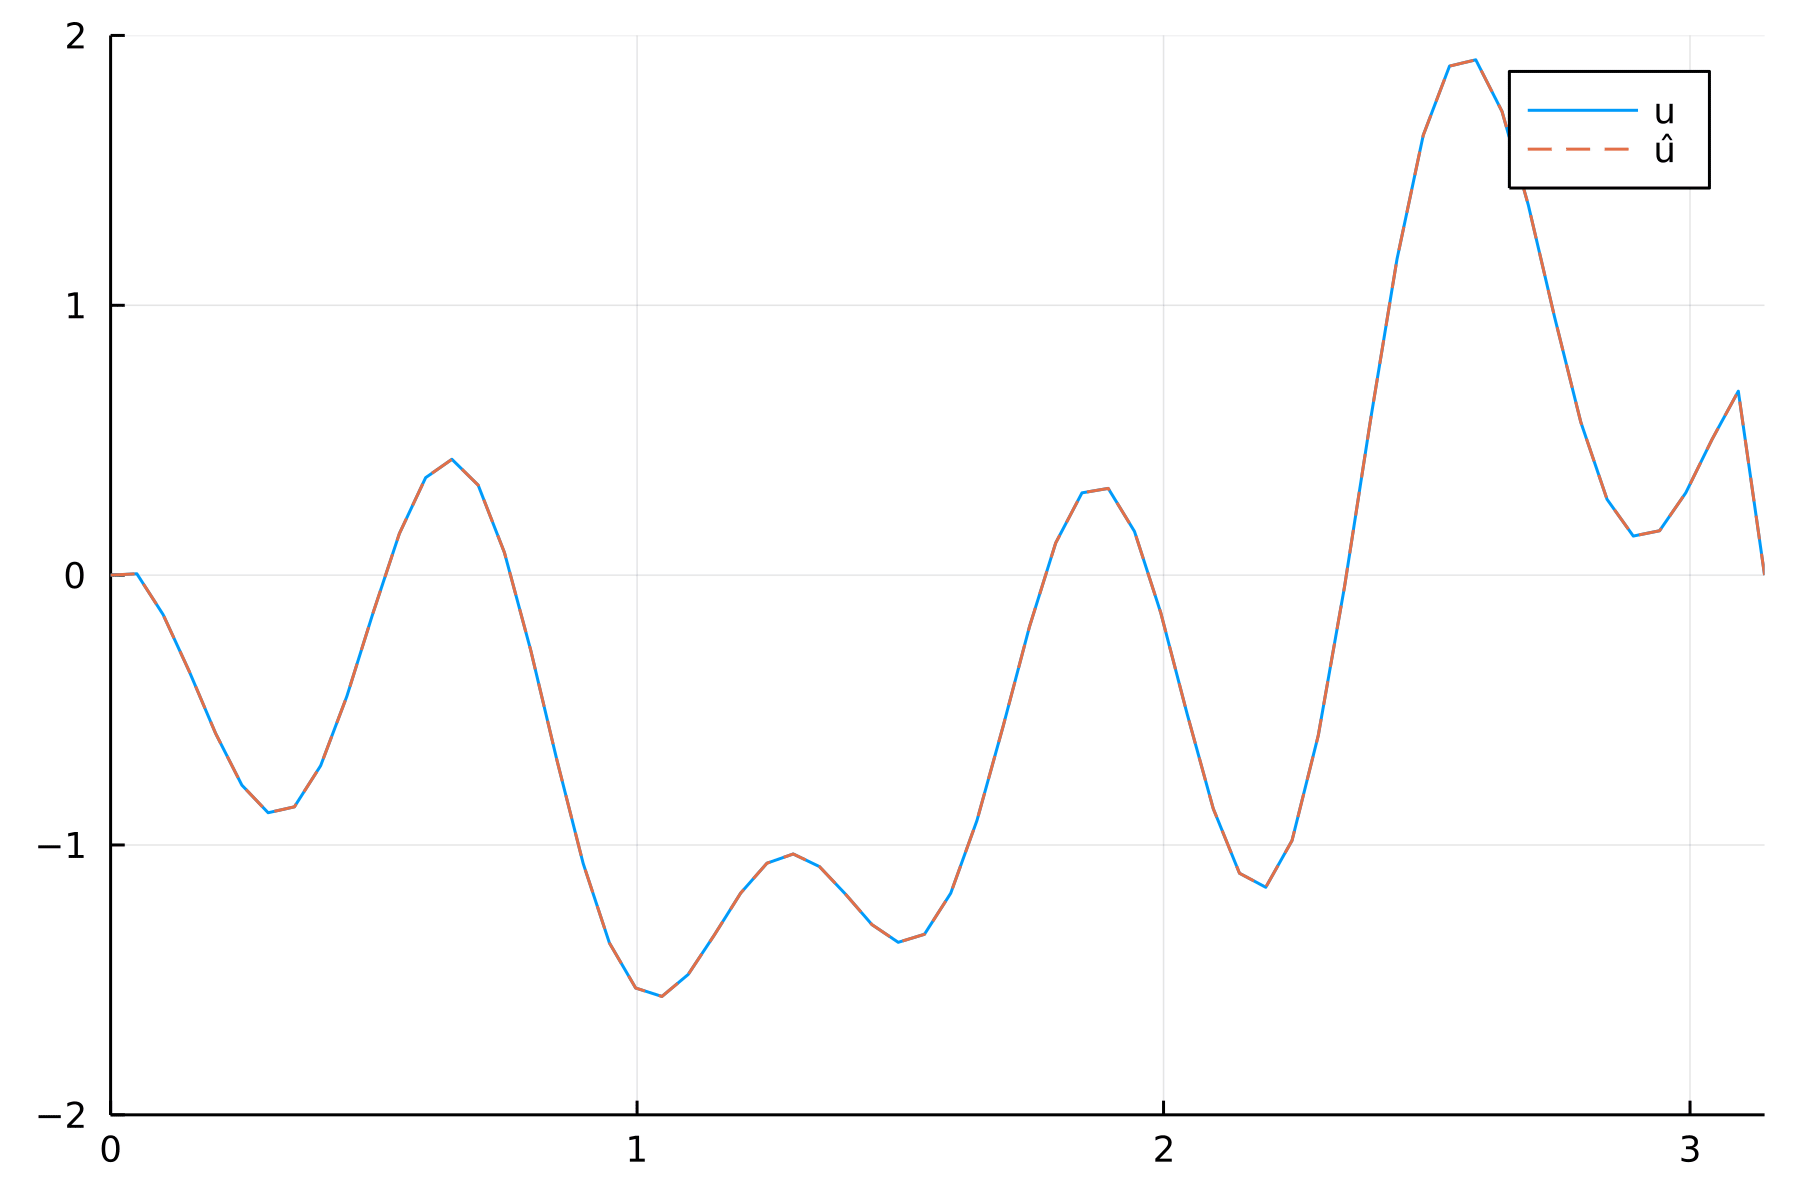

In [21]:
animate_snapshot_prediction(u1, u1, collect(LinRange(x_min, x_max, 64)), "snapshot_viscous_burgers_nu004_fps15.gif")

### CCDF

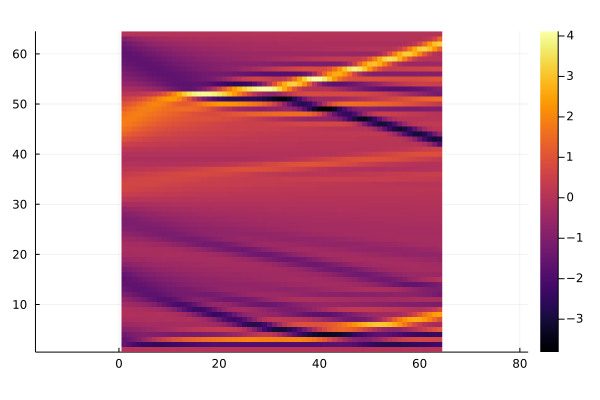

In [9]:
t2, u2 = Equations.get_burgers_ccdf(t, dx, x_n, nu, u0[1, :]);
GraphicTools.show_state(u2, "")

In [10]:
sum(u2; dims=1)

1×64 Matrix{Float64}:
 -21.8664  -21.7499  -21.5724  -21.3392  …  -6.90978  -6.63849  -6.42637

### Pseudo-spectral method

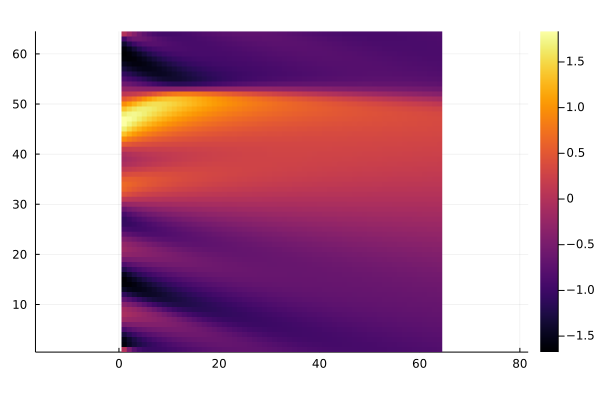

In [11]:
t3, u3 = Equations.get_burgers_fft(t, dx, x_n, nu, u0[1, :]);
GraphicTools.show_state(u3, "")

### Thesis screenshots

In [12]:
u0 = InitialFunctions.high_dim_random_init(t, x, 10);
high_t, high_dim = Generator.burgers_snapshot_generator(t_max, t_min, x_max, x_min, t_n * 32, x_n * 32, nu, 2);

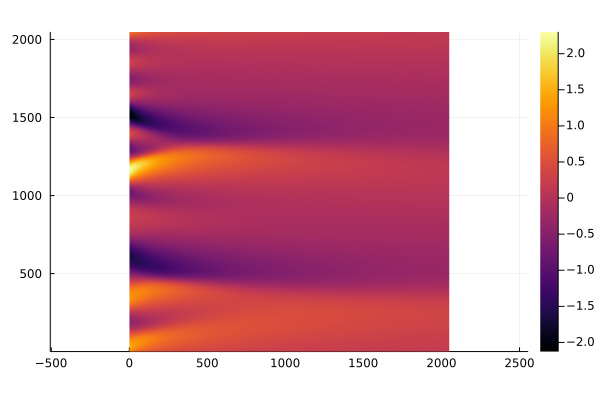

In [13]:
low_dim = ProcessingTools.downsampling(high_dim, 32);
low_t = LinRange(t_min, t_max, t_n);
GraphicTools.show_state(high_dim, "")

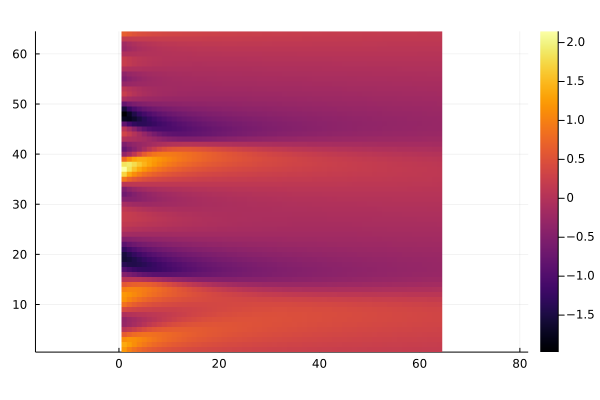

In [14]:
GraphicTools.show_state(low_dim, "")

┌ Warning: dt(2.220446049250313e-16) <= dtmin(2.220446049250313e-16) at t=0.06604681691461026. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase /Users/vdesgrange/.julia/packages/SciMLBase/Mn52A/src/integrator_interface.jl:505


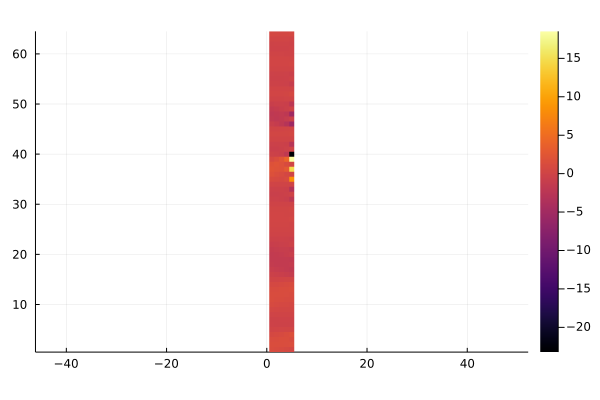

In [15]:
t4, u4 = Equations.get_burgers_fft(t, dx, x_n, 0.0001, low_dim[:, 1]);
GraphicTools.show_state(u4, "")

### POD-GC

In [ ]:
t, u2 = Equations.get_burgers_fft(t, dx, x_n, 0.03, u0[1, :]);
GraphicTools.show_state(u2, "Snapshot") # need to reverse u, odesolver switch dimensions

In [ ]:
plot(x, t, u2, st = :surface, xlabel = "t", ylabel = "x", zlabel = "u")
plot!(dpi=300)

In [ ]:
# ta, u_a = Generator.burgers_snapshot_generator(t_max, t_min, x_max, x_min, t_n, x_n, nu, 1);
# GraphicTools.show_state(u_a, "Snapshot generator")

In [ ]:
bas, ū = POD.generate_pod_basis(u3, true);
ϕ = bas.modes;
coeff = bas.coefficients;
tmp = ϕ[:, 1:3] * coeff[1:3, :] .+ ū;
# display(
#     plot(
#         GraphicTools.show_state(u, ""),
#         GraphicTools.show_state(u2, ""),
#         GraphicTools.show_state(tmp, ""),
#         GraphicTools.show_err(u2, tmp, "");
#         layout = (2, 2)
#     )
# );

In [ ]:
GraphicTools.show_state(tmp, "")
# GraphicTools.show_err(u2, tmp, "")

In [ ]:
Ū = Equations.galerkin_projection(t, u3, ϕ[:, 1:3], 0., dx, dt);
# display(
#     plot(
#         GraphicTools.show_state(u2, ""),
#         GraphicTools.show_state(Ū, ""),
#         GraphicTools.show_err(u2, Ū, ""),
#         GraphicTools.show_err(u2, Ū, "");
#         layout = (2, 2)
#     )
# );
GraphicTools.show_state(Ū, "")
# GraphicTools.show_err(u2, Ū, "")

## Analytical solution initial conditions

In [ ]:
#u0 = InitialFunctions.advecting_shock(t, x, nu);
u0 = exp.(-16 .* (x.^2));
t, u = Equations.get_burgers_fft(t, dx, x_n, nu, u0);
GraphicTools.show_state(u, "Snapshot")

In [ ]:
plot(t, x, u, st = :surface, xlabel = "t", ylabel = "x", zlabel = "u")
plot!(dpi=300)

---
# Generate data

In [40]:
# dataset_1k = Generator.generate_burgers_training_dataset(t_max, t_min, x_max, x_min, t_n, x_n, nu, 1024, 2, 1, false, "./src/dataset/burgers_high_dim_training_set_2.jld2", "training_set");
# high_dataset = Generator.read_dataset("./src/dataset/burgers_high_dim_training_set.jld2")["training_set"];
# coarse_dataset = Generator.read_dataset("./src/dataset/burgers_coarse_training_set.jld2")["training_set"];
# nu_dataset = Generator.read_dataset("./src/examples/burgers/dataset/burgers_high_dim_nu_variational_dataset.jld2")["training_set"];
dataset = Generator.read_dataset("./src/examples/burgers/dataset/high_dim_256_set_j173.jld2")["training_set"];

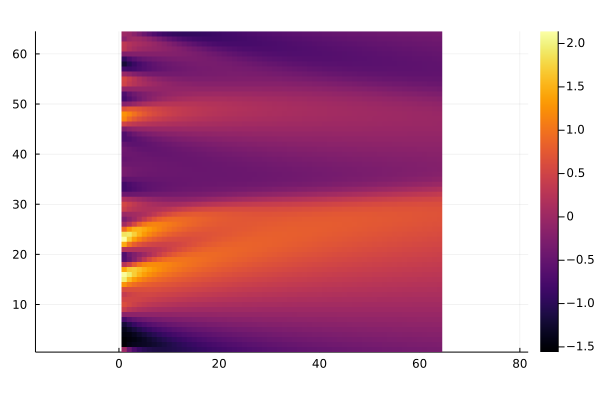

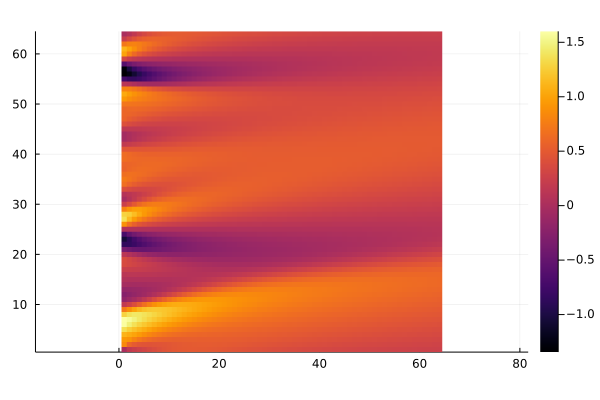

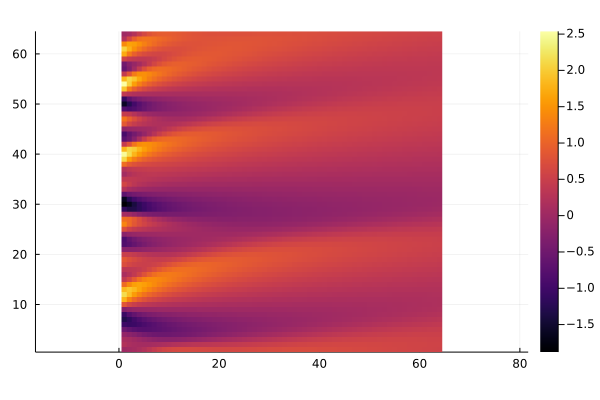

In [41]:
function check_training_dataset(dataset)
    for i in range(1, 3, step=1)
        a, b = dataset[i];
        display(GraphicTools.show_state(b, ""))
    end
end

check_training_dataset(dataset)

## Experiment with different models

### Heat linear model

In [ ]:
t, init_set, true_set = ProcessingTools.process_dataset(high_dataset, false);
net = Models.HeatModel(x_n);
result = burgers_training(net, 100, init_set, true_set, t);

In [ ]:
K = reshape(result, (x_n, x_n))
t, u0, u = Generator.get_burgers_batch(t_max, t_min, x_max, x_min, t_n, x_n, nu, 2);
u_pred = Array(S(K, u0, t));  # S function at bottom of notebook

plot(
    GraphicTools.show_state(u, ""),
    GraphicTools.show_state(u_pred, ""),
    GraphicTools.show_state((u_pred .- u), "");
    layout = (1, 3),
)

##### Operator reconstructed

Visualize reconstructed operator and check efficiency to determine solution from unknown sample

In [ ]:
function f(u, K, t)
  return K * u
end

function S(net, u0, t)
  tspan = (t[1], t[end])
  prob = ODEProblem(ODEFunction(f), copy(u0), tspan, net)
  sol = solve(prob, Tsit5(), saveat=t, reltol=1e-8, abstol=1e-8)
end

In [ ]:
K = reshape(result, (x_n, x_n))
GraphicTools.show_state(reverse(K; dims = 1), "Operator K")

In [ ]:
t, u0, u = Generator.get_burgers_batch(t_max, t_min, x_max, x_min, t_n, x_n, nu, 2);
u_pred = Array(S(K, u0, t));
plot(
    GraphicTools.show_state(u, ""),
    GraphicTools.show_state(u_pred, "");
    layout = (1, 2),
)

## Analysis

In [ ]:
function test_simulation(net, result, n, typ)
    mse_tot = 0
    l1_tot = 0
    for i in n
        t, u0, u_true = Generator.get_burgers_batch(t_max, t_min, x_max, x_min, t_n, x_n, nu, typ);
        prob_neuralode = DiffEqFlux.NeuralODE(net, (t[1], t[end]), Tsit5(), saveat=t)
        u_pred = prob_neuralode(u0, result)

        mse_tot += Objectives.mseloss(u_pred, u_true)
        l1_tot += sum(abs.(u_pred .- u_true))
    end
    
    return mse_tot / n, l1_tot / n
end

--- 
# Training with flux

In [ ]:
add_dim(x::Array{Float64, 1}) = reshape(x, (size(x)[1], 1, 1, 1))
add_dim(x::Array) = reshape(x, (size(x)[1], 1, 1, size(x)[2]))
del_dim(x::Array) = reshape(x, (size(x)[1], size(x)[4], size(x)[5]))

In [ ]:
function check_result(nn, res, typ)
    t, u0, u = Generator.get_burgers_batch(t_max, t_min, x_max, x_min, t_n, x_n, nu, typ);
    prob_neuralode = DiffEqFlux.NeuralODE(nn, (t[1], t[end]), Tsit5(), saveat=t)
    u_pred = prob_neuralode(add_dim(u0), res)
#     prob = ODEProblem{false}(nn, Nothing, (Nothing, Nothing));
#     u_pred = Array(solve(prob, Tsit5(), u0=add_dim(u0), p=p, abstol=1e-9, reltol=1e-9, saveat=t, sensealg=DiffEqSensitivity.BacksolveAdjoint()));
    
    plot(
        GraphicTools.show_state(u, ""),
        GraphicTools.show_state(hcat(u_pred.u...), ""),
        GraphicTools.show_err(hcat(u_pred.u...), u, "");
        layout = (1, 3),
    )
end

In [25]:
function training(model, epochs, dataset, batch_size, ratio, lr, noise=0., reg=0., cuda=false)
   if cuda && CUDA.has_cuda()
      device = Flux.gpu
      CUDA.allowscalar(true) # false
      @info "Training on GPU"
  else
      device = Flux.cpu
      @info "Training on CPU"
  end

  model = model |> device
  opt = Flux.Optimiser(Flux.WeightDecay(reg), Flux.ADAM(lr, (0.9, 0.999), 1.0e-8))
  ltrain = 0.;
  lval = 0.;
  losses = [];

  @info("Loading dataset")
  (train_loader, val_loader) = ProcessingTools.get_data_loader(dataset, batch_size, ratio, false, false);

  @info("Building model")
  p, re = Flux.destructure(model);
  net(u, p, t) = re(p)(u);

  prob = ODEProblem{false}(net, Nothing, (Nothing, Nothing));

  function predict_neural_ode(x, t)
    tspan = (t[1], t[end]);
    _prob = remake(prob; u0=x, p=p, tspan=tspan);
    Array(solve(_prob, Tsit5(), u0=x, p=p, abstol=1e-9, reltol=1e-9, saveat=t, sensealg=DiffEqSensitivity.BacksolveAdjoint()));
  end

  function loss(x, y, t)
    u_pred = predict_neural_ode(Reg.gaussian_augment(x, noise), t[1]);
    ŷ = u_pred;
#     u_pred = predict_neural_ode(add_dim(x), t[1]);
#     ŷ = Reg.gaussian_augment(del_dim(u_pred), noise);
    l = Flux.mse(ŷ, permutedims(y, (1, 3, 2))) # + Reg.l2(p, reg);
    return l;
  end

  function traincb()
    ltrain = 0;
    for (x, y, t) in train_loader
      ltrain += loss(x, y, t);
    end
    ltrain /= (train_loader.nobs / train_loader.batchsize);
    @show(ltrain);
  end

  function val_loss(x, y, t)
    u_pred = predict_neural_ode(x, t[1]);
    ŷ = u_pred;
    # u_pred = predict_neural_ode(add_dim(x), t[1]);
    # ŷ = del_dim(u_pred);
    l = Flux.mse(ŷ, permutedims(y, (1, 3, 2)))
    return l;
  end

  function evalcb()
    lval = 0;
    for (x, y, t) in val_loader
      # (x, y, t) = (x, y, t) |> device;
      lval += val_loss(x, y, t);
    end
    lval /= (val_loader.nobs / val_loader.batchsize);
    @show(lval);
  end

  @info("Train")
  trigger = Flux.plateau(() -> ltrain, 20; init_score = 1, min_dist = 1f-5);
  Flux.@epochs epochs begin
    Flux.train!(loss, Flux.params(p), train_loader, opt, cb = [traincb, evalcb]);
    trigger() && break;
  end

  return re(p), p, ltrain, lval
end

training (generic function with 4 methods)

In [36]:
function main()
  batch_size = 32;
  epochs = 100;

  data = Generator.read_dataset("./src/examples/burgers/dataset/high_dim_256_set_j173.jld2")["training_set"];
  # model = Models.CAE(64, 2, 3);
  model = Models.FeedForwardNetwork(64, 3, 48);
  K, p = training(model, epochs, data, batch_size, 0.75, 0.01, 0.05, 1.0e-7, false);
  return K, p
end

K, p = main()

┌ Info: Training on CPU
└ @ Main In[25]:8
┌ Info: Loading dataset
└ @ Main In[25]:17
┌ Info: Building model
└ @ Main In[25]:20
┌ Info: Train
└ @ Main In[25]:69
┌ Info: Epoch 1
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.6565611598054659
lval = 0.6656319259487294
ltrain = 0.6065268521738988
lval = 0.6203715935542533
ltrain = 0.5675752732688478
lval = 0.5863100085291197
ltrain = 0.535247567932986
lval = 0.5580411515501718
ltrain = 0.5056078339493928
lval = 0.5330387102647453
ltrain = 0.4800745465937763
lval = 0.5080835744108022


┌ Info: Epoch 2
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.4520851072973782
lval = 0.4851347588780332
ltrain = 0.4290095987542386
lval = 0.46353945453648393
ltrain = 0.405066632606029
lval = 0.44264896486550304
ltrain = 0.38318935412499044
lval = 0.4223678486306382
ltrain = 0.3620527822596877
lval = 0.40315592557333413
ltrain = 0.3433688154215735
lval = 0.38515214033897666


┌ Info: Epoch 3
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.3243443921958313
lval = 0.3681010788576483
ltrain = 0.30942268205000717
lval = 0.35222211648077706
ltrain = 0.29300283800198174
lval = 0.33723566100926405
ltrain = 0.2796005236886516
lval = 0.3226155428574695
ltrain = 0.26582573308325935
lval = 0.30888842122383864
ltrain = 0.25384572095660063
lval = 0.29566295282399485


┌ Info: Epoch 4
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.24080807709203533
lval = 0.28316676484550746
ltrain = 0.230543209048465
lval = 0.2713786802252764
ltrain = 0.2194144596057885
lval = 0.2602566433946739
ltrain = 0.2087908894183654
lval = 0.2493651079164501
ltrain = 0.200030747785232
lval = 0.23893021018590738
ltrain = 0.19109272086877946
lval = 0.22894665508541664


┌ Info: Epoch 5
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.18263528772399987
lval = 0.21963946446493487
ltrain = 0.1735779493006262
lval = 0.21104059201316738
ltrain = 0.16706394381463321
lval = 0.2031191610792052
ltrain = 0.15990470564324008
lval = 0.19578755592135322
ltrain = 0.15429685134911467
lval = 0.18888973988587715
ltrain = 0.14797028062863782
lval = 0.18230848450277945


┌ Info: Epoch 6
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.14323024329305922
lval = 0.1762224025817099
ltrain = 0.13934064490533893
lval = 0.17056127974132015
ltrain = 0.13443026352952156
lval = 0.16522277353973014
ltrain = 0.1298952768789097
lval = 0.16025942488471728
ltrain = 0.12649327698258792
lval = 0.15567230717792177
ltrain = 0.12307247593250303
lval = 0.15137684458982498


┌ Info: Epoch 7
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.11931087188129741
lval = 0.14746323777241854
ltrain = 0.11648584729543658
lval = 0.14376038900906113
ltrain = 0.11368887095618081
lval = 0.14059974935249597
ltrain = 0.11179717393660697
lval = 0.13751991419540832
ltrain = 0.10950846455033923
lval = 0.13459799688429958
ltrain = 0.10583849147441293
lval = 0.13168153878931216


┌ Info: Epoch 8
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.10423483321605369
lval = 0.128914277110147
ltrain = 0.101807303849682
lval = 0.12639114411090263
ltrain = 0.1001113987886388
lval = 0.12409705517048907
ltrain = 0.0983271866756481
lval = 0.1220196526339452
ltrain = 0.09684771577376268
lval = 0.12000882223594761
ltrain = 0.0953203397079155
lval = 0.11790596564420851


┌ Info: Epoch 9
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.09346938076267114
lval = 0.11604613029287844
ltrain = 0.09163051720300759
lval = 0.11431457220225208
ltrain = 0.09022169932123214
lval = 0.11266835525674754
ltrain = 0.08870235074132003
lval = 0.1110040030275293
ltrain = 0.0875372389193461
lval = 0.10930727545399616
ltrain = 0.0864445334807401
lval = 0.107596342908183


┌ Info: Epoch 10
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.08534533735067636
lval = 0.10594315512206978
ltrain = 0.08407901409040042
lval = 0.10437866609628753
ltrain = 0.08253764942015192
lval = 0.10299858631379168
ltrain = 0.08148237959362216
lval = 0.10181305189764285
ltrain = 0.08097984388660932
lval = 0.1007340029787796
ltrain = 0.07986577663607423
lval = 0.09959137755623272


┌ Info: Epoch 11
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.07914100170084504
lval = 0.09851526422209925
ltrain = 0.07783906803073871
lval = 0.09763874963360522
ltrain = 0.07728161319619511
lval = 0.09687165302794773
ltrain = 0.07645877532278096
lval = 0.09602285113165987
ltrain = 0.07562269897709227
lval = 0.09518496918155425
ltrain = 0.07442448607181162
lval = 0.09439743721411037


┌ Info: Epoch 12
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.07409612345799726
lval = 0.09368102681975646
ltrain = 0.07305688830867578
lval = 0.09307623130465449
ltrain = 0.07243161540423393
lval = 0.09266828340838035
ltrain = 0.0722320279547612
lval = 0.09231410926977957
ltrain = 0.07147486824980097
lval = 0.09160759765253561
ltrain = 0.07103474314287621
lval = 0.09063620327382663


┌ Info: Epoch 13
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.07033590626965154
lval = 0.08980730932190494
ltrain = 0.06992811770433749
lval = 0.08912293659106149
ltrain = 0.07013517646065542
lval = 0.08865203366126766
ltrain = 0.06970976698563223
lval = 0.08823332641633252
ltrain = 0.06879831525077508
lval = 0.08743201558320896
ltrain = 0.06774030054320967
lval = 0.08706493297645085


┌ Info: Epoch 14
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.06731319357702052
lval = 0.0870135413900733
ltrain = 0.0669521534039851
lval = 0.08732727585962681
ltrain = 0.06716660194541767
lval = 0.08746426299702827
ltrain = 0.06628300971227989
lval = 0.08702004701497218
ltrain = 0.06583314637292503
lval = 0.08664685214958565
ltrain = 0.06519715339793528
lval = 0.08575539727027376


┌ Info: Epoch 15
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.06458300506212926
lval = 0.08476388455111168
ltrain = 0.06436225950357118
lval = 0.08390106203388255
ltrain = 0.06382486461493382
lval = 0.08340983614609557
ltrain = 0.06379040248349625
lval = 0.08286782415255978
ltrain = 0.06333983977073442
lval = 0.08243144538247586
ltrain = 0.062086527729355155
lval = 0.08195649258856985


┌ Info: Epoch 16
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.06229839473550783
lval = 0.08182012757779862
ltrain = 0.06176901169720952
lval = 0.08209951851167675
ltrain = 0.06172283607874592
lval = 0.0818640170864735
ltrain = 0.061443869969204874
lval = 0.08153137503099661
ltrain = 0.06108530191570491
lval = 0.08118774624958036
ltrain = 0.06032367367734285
lval = 0.0807214444308632


┌ Info: Epoch 17
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.06010718835089576
lval = 0.08037731305464382
ltrain = 0.059662328895264904
lval = 0.0800831085494178
ltrain = 0.059070811343143466
lval = 0.07973201100381877
ltrain = 0.05922099746963305
lval = 0.07950429807884446
ltrain = 0.05887693108876102
lval = 0.07887935138876533
ltrain = 0.05838287524229458
lval = 0.07836706702705476


┌ Info: Epoch 18
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.05850777544697375
lval = 0.0780589021043809
ltrain = 0.058060514270279966
lval = 0.07807576416311737
ltrain = 0.05783416128801239
lval = 0.078316884229304
ltrain = 0.057219398839641146
lval = 0.07838535920585073
ltrain = 0.056984592821130074
lval = 0.07802320364598692
ltrain = 0.05604997259697218
lval = 0.07687351871964321


┌ Info: Epoch 19
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.056411584208343045
lval = 0.07621016749635627
ltrain = 0.056762790517750884
lval = 0.07621675458532012
ltrain = 0.0563582921980329
lval = 0.07624789153357739
ltrain = 0.0558336266633157
lval = 0.07588294924089412
ltrain = 0.05539683841651344
lval = 0.07581503571109521
ltrain = 0.0546899026403816
lval = 0.07552407461775357


┌ Info: Epoch 20
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.054282489225907234
lval = 0.07551725066453818
ltrain = 0.05415235096682453
lval = 0.07511134985644796
ltrain = 0.05417074384269028
lval = 0.0748975106514236
ltrain = 0.05383733551036222
lval = 0.0751285766151876
ltrain = 0.05405438285850386
lval = 0.07470904684248275
ltrain = 0.05323959362187449
lval = 0.07436289988135542


┌ Info: Epoch 21
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.05302882798273308
lval = 0.07452965250605592
ltrain = 0.05300212683662767
lval = 0.07499401959673802
ltrain = 0.05275893433623447
lval = 0.07524555210016173
ltrain = 0.05321687608465128
lval = 0.07460113005290679
ltrain = 0.05286156460248864
lval = 0.0739349153523229
ltrain = 0.051885008587362225
lval = 0.07281172413199452


┌ Info: Epoch 22
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.0516923781090514
lval = 0.07263136125535476
ltrain = 0.051996160882939436
lval = 0.07305173897675979
ltrain = 0.052114908762222835
lval = 0.07361855360281036
ltrain = 0.05184842805854731
lval = 0.0735550482810686
ltrain = 0.05077350953787724
lval = 0.07292622634984094
ltrain = 0.050292485922389586
lval = 0.07228680822136149


┌ Info: Epoch 23
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.05008555184366804
lval = 0.0724219452720685
ltrain = 0.05113049163295802
lval = 0.07305432746906228
ltrain = 0.05086146196967651
lval = 0.07293535360715037
ltrain = 0.05026976575043949
lval = 0.07259873763190954
ltrain = 0.04986214209843345
lval = 0.07230256989957358
ltrain = 0.0494132239388824
lval = 0.07134129687189167


┌ Info: Epoch 24
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.04906736345006632
lval = 0.07104546189540682
ltrain = 0.048817889737029795
lval = 0.07138966963782623
ltrain = 0.04870566747578873
lval = 0.07133465941841388
ltrain = 0.048427100982661425
lval = 0.07103624377557549
ltrain = 0.048222578625095984
lval = 0.07088041645448703
ltrain = 0.048091480904710326
lval = 0.07134845648080382


┌ Info: Epoch 25
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.048499750104847306
lval = 0.07198946359384006
ltrain = 0.04859056090617376
lval = 0.0719790550567796
ltrain = 0.04768336298394297
lval = 0.07089515283248576
ltrain = 0.04748067041335174
lval = 0.07014498862240595
ltrain = 0.047806864969118845
lval = 0.07018520971470568
ltrain = 0.047982993141738484
lval = 0.07027535985394749


┌ Info: Epoch 26
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.0477157467575525
lval = 0.07016276698111253
ltrain = 0.047477202233765066
lval = 0.06957668771810896
ltrain = 0.04710169885427618
lval = 0.06916252384691905
ltrain = 0.04669849330182344
lval = 0.06894814207340429
ltrain = 0.046258859145565386
lval = 0.06895090937388956
ltrain = 0.0458854800289575
lval = 0.06891194981833876


┌ Info: Epoch 27
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.046024856152946665
lval = 0.06932485596142028
ltrain = 0.04589066810889322
lval = 0.06896691454444359
ltrain = 0.045769538259823606
lval = 0.06870892487566034
ltrain = 0.04620642992521163
lval = 0.06882726743959293
ltrain = 0.046133284709033835
lval = 0.06852494265585099
ltrain = 0.04573882512482677
lval = 0.0684531756638323


┌ Info: Epoch 28
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.045482418541047016
lval = 0.06831847422187175
ltrain = 0.04554892120712909
lval = 0.06820389008619987
ltrain = 0.045206982286406745
lval = 0.06756122463150775
ltrain = 0.04501258157410807
lval = 0.06787366177529203
ltrain = 0.04549550425787264
lval = 0.06841155315975675
ltrain = 0.04488119160786419
lval = 0.06853547512876901


┌ Info: Epoch 29
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.044280630917178765
lval = 0.06870692142683649
ltrain = 0.04440831345775793
lval = 0.06885910607654107
ltrain = 0.04435448424881924
lval = 0.06882689277402664
ltrain = 0.04396269168376558
lval = 0.0687973347877536
ltrain = 0.04371431603378365
lval = 0.06782794367636602
ltrain = 0.043727057135513024
lval = 0.0674366244732509


┌ Info: Epoch 30
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.04413332762437211
lval = 0.06742377757428847
ltrain = 0.04411766871589596
lval = 0.06715915087806379
ltrain = 0.04379307074716335
lval = 0.0666207800757107
ltrain = 0.042783277187116366
lval = 0.06600250771789318
ltrain = 0.04262778128090743
lval = 0.06603940491724636
ltrain = 0.043249942858476
lval = 0.06706127546453088


┌ Info: Epoch 31
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.04389941163010919
lval = 0.06821093221518888
ltrain = 0.04319714058100362
lval = 0.06776259796806386
ltrain = 0.04206781357658095
lval = 0.0667286107335898
ltrain = 0.04206326656873827
lval = 0.06595384644307732
ltrain = 0.04169010460741363
lval = 0.06590224631480118
ltrain = 0.04225257630044212
lval = 0.06611867930669066


┌ Info: Epoch 32
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.04227012613472881
lval = 0.06644620891043505
ltrain = 0.041893080450348376
lval = 0.06623302165365144
ltrain = 0.04116775362357851
lval = 0.06568859771694725
ltrain = 0.040900833767290236
lval = 0.06539735105185854
ltrain = 0.04096673627607065
lval = 0.06555825198303859
ltrain = 0.04111076366143056
lval = 0.0659146038638698


┌ Info: Epoch 33
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.041581492433744746
lval = 0.06610442234719696
ltrain = 0.04150868037511701
lval = 0.06613681082753309
ltrain = 0.04138031138505857
lval = 0.06622683456991257
ltrain = 0.040525680262076196
lval = 0.06576488781618836
ltrain = 0.04022608066920708
lval = 0.06531317103701137
ltrain = 0.041465297450125095
lval = 0.06655326408701359


┌ Info: Epoch 34
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.04235288305803989
lval = 0.06761216144589066
ltrain = 0.040783864937756
lval = 0.06621019309528282
ltrain = 0.039916463316490326
lval = 0.06506737518143862
ltrain = 0.03985669835135285
lval = 0.0651157272502905
ltrain = 0.040760621238460366
lval = 0.06554789521915994
ltrain = 0.041453409319338004
lval = 0.06585668187239153


┌ Info: Epoch 35
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.04107191996419146
lval = 0.06532926224912826
ltrain = 0.04053837539106169
lval = 0.06499840922083226
ltrain = 0.040173281556654394
lval = 0.06501211272883717
ltrain = 0.03948124640488413
lval = 0.06461754417784102
ltrain = 0.03902505800527076
lval = 0.06410418719815948
ltrain = 0.03878129597472285
lval = 0.06361377467864252


┌ Info: Epoch 36
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.03844763992149613
lval = 0.06331654251879694
ltrain = 0.03838127544975651
lval = 0.06361021166412385
ltrain = 0.03952685544783456
lval = 0.06407913433207676
ltrain = 0.03948095024522367
lval = 0.06443354134492313
ltrain = 0.03904892679802475
lval = 0.06405929766832623
ltrain = 0.0386929734280218
lval = 0.06387989485651233


┌ Info: Epoch 37
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.03901300264749515
lval = 0.0637103074197988
ltrain = 0.03901921753379403
lval = 0.063295009781293
ltrain = 0.03841826260443334
lval = 0.06263729239111314
ltrain = 0.03829992380307328
lval = 0.06225665423563107
ltrain = 0.03805901683707487
lval = 0.06224928983823511
ltrain = 0.03784888297680842
lval = 0.0624477308343148


┌ Info: Epoch 38
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.03808794097398385
lval = 0.06306332303062984
ltrain = 0.03807244575269236
lval = 0.06343883464080902
ltrain = 0.03773459084043555
lval = 0.06356315577390134
ltrain = 0.03701655212967635
lval = 0.06333301760261179
ltrain = 0.03676573118960948
lval = 0.06283921454018289
ltrain = 0.03662117958228921
lval = 0.06266241085970758


┌ Info: Epoch 39
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.036958933182006916
lval = 0.06240397857815899
ltrain = 0.03650244278502956
lval = 0.06213254656864789
ltrain = 0.036014593187421534
lval = 0.06186509666053592
ltrain = 0.03609350085619876
lval = 0.06159609215325484
ltrain = 0.03614840013329534
lval = 0.061386979645304665
ltrain = 0.035469952517314
lval = 0.0610639992958548


┌ Info: Epoch 40
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.03618057016557231
lval = 0.06168831952313049
ltrain = 0.036010061179448584
lval = 0.061952833578771294
ltrain = 0.035350545266199886
lval = 0.060867172080064987
ltrain = 0.0350242437491635
lval = 0.06082582622767661
ltrain = 0.03525299990115116
lval = 0.06108093805309121
ltrain = 0.034945709590734585
lval = 0.06110453029604271


┌ Info: Epoch 41
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.03518040784021564
lval = 0.06165797133279297
ltrain = 0.035516263195753135
lval = 0.062399158766060156
ltrain = 0.034726787133212096
lval = 0.06212775510060911
ltrain = 0.03398393656208253
lval = 0.061381371092693426
ltrain = 0.03414799745225352
lval = 0.061895531633629375
ltrain = 0.03528492408231857
lval = 0.0630131097722887


┌ Info: Epoch 42
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.03522029755111153
lval = 0.06302891094573458
ltrain = 0.03464034963006699
lval = 0.061844190194642976
ltrain = 0.033850778476795663
lval = 0.05994951658551847
ltrain = 0.03428814360587301
lval = 0.0597086505989524
ltrain = 0.03486599119291554
lval = 0.059808614784000486
ltrain = 0.03453557988537744
lval = 0.060147415432700004


┌ Info: Epoch 43
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.033825660412205305
lval = 0.05974356948521618
ltrain = 0.03329282386985854
lval = 0.059938078265914865
ltrain = 0.03333659330073613
lval = 0.06010954933283971
ltrain = 0.03345894870093652
lval = 0.06086815223049934
ltrain = 0.03368500604590228
lval = 0.06133751253424058
ltrain = 0.03355726518576652
lval = 0.06133254240671172


┌ Info: Epoch 44
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.03305673410960601
lval = 0.06084299795210427
ltrain = 0.03326356994299074
lval = 0.06124594651331553
ltrain = 0.03348979113351735
lval = 0.061745939320724016
ltrain = 0.03317699815190081
lval = 0.060450525087579116
ltrain = 0.03338407688360995
lval = 0.0596867527215237
ltrain = 0.032971631013031945
lval = 0.059258659397808965


┌ Info: Epoch 45
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.03243815113564621
lval = 0.05907418477100686
ltrain = 0.03260424787060846
lval = 0.059538121109410494
ltrain = 0.03279178263313117
lval = 0.06023233449538343
ltrain = 0.03243276690672488
lval = 0.0603385477665664
ltrain = 0.03199079069187053
lval = 0.060242100785550784
ltrain = 0.03192478400737734
lval = 0.05955463578506129


┌ Info: Epoch 46
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.03193896185771364
lval = 0.05907944648110571
ltrain = 0.0318616546538813
lval = 0.05900892788145483
ltrain = 0.03173246943942564
lval = 0.05910764996820023
ltrain = 0.03162363332608769
lval = 0.05934416858594518
ltrain = 0.031760440122559165
lval = 0.059138301045459855
ltrain = 0.031735582147831544
lval = 0.05915178903135283


┌ Info: Epoch 47
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.03143682080688171
lval = 0.05939986178519621
ltrain = 0.031354465482736106
lval = 0.05954690027365962
ltrain = 0.031130977085099487
lval = 0.05984345577504384
ltrain = 0.03097853092248029
lval = 0.05997860016161233
ltrain = 0.03160315394749921
lval = 0.05968094643318246
ltrain = 0.031121913725985537
lval = 0.05858376571169684


┌ Info: Epoch 48
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.031637978709978004
lval = 0.05893880484977404
ltrain = 0.03109223166624008
lval = 0.05852922964908066
ltrain = 0.030666623996973813
lval = 0.05857582384515256
ltrain = 0.03069167101196682
lval = 0.059074063935626524
ltrain = 0.03159651619117541
lval = 0.06011610613855395
ltrain = 0.030921533678010562
lval = 0.05992236432047768


┌ Info: Epoch 49
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.030670689899243726
lval = 0.05947132975320228
ltrain = 0.030905529514474516
lval = 0.059377683072298716
ltrain = 0.030667721033087948
lval = 0.058516931667799206
ltrain = 0.030137358536260688
lval = 0.05722003854006199
ltrain = 0.030314330816604604
lval = 0.05735023409601641
ltrain = 0.031030755508238042
lval = 0.0586111193947385


┌ Info: Epoch 50
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.0299818999218084
lval = 0.058236251270569285
ltrain = 0.029830770372745324
lval = 0.05804345923583442
ltrain = 0.029890185615835754
lval = 0.05839115444826812
ltrain = 0.029639958609690542
lval = 0.05763744094459927
ltrain = 0.030245287582379266
lval = 0.057812299170562756
ltrain = 0.02967152644002281
lval = 0.057023108161478785


┌ Info: Epoch 51
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.029547379942388315
lval = 0.05583946753427042
ltrain = 0.029927042105942603
lval = 0.056258473113370976
ltrain = 0.02970208132384494
lval = 0.05673730476588113
ltrain = 0.029085133719436107
lval = 0.05709071902112583
ltrain = 0.029030657459753684
lval = 0.05806849700031638
ltrain = 0.029633291644905815
lval = 0.059155853101528544


┌ Info: Epoch 52
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.029663111803980416
lval = 0.05924559655162091
ltrain = 0.029072986294363338
lval = 0.0588110836909977
ltrain = 0.029166621760566825
lval = 0.05838219110127815
ltrain = 0.028761438750423755
lval = 0.05683010000242646
ltrain = 0.028541370559742273
lval = 0.05569184553814181
ltrain = 0.028735005075769718
lval = 0.055351471963265064


┌ Info: Epoch 53
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.029130226314492826
lval = 0.055509919269954175
ltrain = 0.028885226254416183
lval = 0.05537859415599536
ltrain = 0.02855929882648069
lval = 0.055627840846136985
ltrain = 0.028576858216672746
lval = 0.056703504477184655
ltrain = 0.028096513902981703
lval = 0.0571243476529535
ltrain = 0.028945190173631275
lval = 0.05837588948278295


┌ Info: Epoch 54
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.028543814338536522
lval = 0.058153643758247574
ltrain = 0.029028962179741703
lval = 0.058241753095174764
ltrain = 0.028508931365035347
lval = 0.05714488416631178
ltrain = 0.028063755702285448
lval = 0.05640607947475789
ltrain = 0.028305759862366175
lval = 0.056701089667964166
ltrain = 0.028506732509191945
lval = 0.056528959870050424


┌ Info: Epoch 55
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.02793089628568778
lval = 0.05528452631223878
ltrain = 0.028724123571621792
lval = 0.05605916036789513
ltrain = 0.028109904492369973
lval = 0.05563692708620965
ltrain = 0.02769586266413626
lval = 0.055853347418367796
ltrain = 0.028211394676907225
lval = 0.05740321145522037
ltrain = 0.02841462689790127
lval = 0.057745636564361526


┌ Info: Epoch 56
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.02907135748199961
lval = 0.05959815624882537
ltrain = 0.02810613298229442
lval = 0.05887556085571095
ltrain = 0.02839609672773617
lval = 0.0587780017934669
ltrain = 0.027988657925342064
lval = 0.05769651845739959
ltrain = 0.02912059639575465
lval = 0.057280664617311385
ltrain = 0.02804797235871856
lval = 0.055365851110603576


┌ Info: Epoch 57
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.02847518991036002
lval = 0.055330477717513565
ltrain = 0.028978104287311072
lval = 0.054867200043703795
ltrain = 0.027922977299740692
lval = 0.0537559118038391
ltrain = 0.028757588096681008
lval = 0.05510486277291318
ltrain = 0.028335975422324067
lval = 0.05596234212932491
ltrain = 0.027391787402331374
lval = 0.055683094328477664


┌ Info: Epoch 58
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.02796359033891363
lval = 0.05672962328139225
ltrain = 0.028418959092199186
lval = 0.057117068967145024
ltrain = 0.027352852696574767
lval = 0.05654756456651014
ltrain = 0.02689244652233541
lval = 0.05648105121682795
ltrain = 0.02733367981801328
lval = 0.056945581619486554
ltrain = 0.027195312543241534
lval = 0.056051583858175505


┌ Info: Epoch 59
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.026623903187790694
lval = 0.054863858620235254
ltrain = 0.026534988985683478
lval = 0.05467219124486322
ltrain = 0.026981415182925683
lval = 0.05482243739505708
ltrain = 0.026410399722657643
lval = 0.054382433011887554
ltrain = 0.026385643552902422
lval = 0.05444919458168221
ltrain = 0.026619088025843618
lval = 0.055071705236437285


┌ Info: Epoch 60
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.026701538931060222
lval = 0.05546051143732443
ltrain = 0.026115631624803876
lval = 0.05505223796527832
ltrain = 0.025883872823022822
lval = 0.054634447317856924
ltrain = 0.026212695953280876
lval = 0.05488092533600402
ltrain = 0.02562174414822028
lval = 0.05406865532471663
ltrain = 0.026286973367382765
lval = 0.05429126135702708


┌ Info: Epoch 61
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.026097515396689464
lval = 0.05431155149758444
ltrain = 0.02541172999129716
lval = 0.05501758627015753
ltrain = 0.025894413156759073
lval = 0.056530200023131236
ltrain = 0.02537541479064444
lval = 0.05613981113064387
ltrain = 0.025656155841134846
lval = 0.05524023293994193
ltrain = 0.02562982812279067
lval = 0.05410075698667348


┌ Info: Epoch 62
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.025248943573868587
lval = 0.05342937033819024
ltrain = 0.02542467714347228
lval = 0.053821331530930584
ltrain = 0.025341357645109197
lval = 0.053665530755540536
ltrain = 0.025588899260228105
lval = 0.0538117126977588
ltrain = 0.02501364644119049
lval = 0.05365996372570277
ltrain = 0.025159899827907745
lval = 0.05435304146915846


┌ Info: Epoch 63
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.025057973516491586
lval = 0.05433208449431666
ltrain = 0.025233565386280295
lval = 0.05445823803168344
ltrain = 0.024834865846436013
lval = 0.054208276332165684
ltrain = 0.025275990912891216
lval = 0.05451532356349697
ltrain = 0.02543730934933629
lval = 0.05518159529856443
ltrain = 0.02524166964120872
lval = 0.05522313864241098


┌ Info: Epoch 64
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.02491701197252343
lval = 0.05449344646903523
ltrain = 0.025356476209116394
lval = 0.054222776384350094
ltrain = 0.025020243300006673
lval = 0.05405109681495418
ltrain = 0.024821367629419142
lval = 0.054379844319769596
ltrain = 0.0249550376774804
lval = 0.054393792479284754
ltrain = 0.024618975636018076
lval = 0.0540310142515323


┌ Info: Epoch 65
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.024512727788629517
lval = 0.05327478369245229
ltrain = 0.024875372881998623
lval = 0.05352401101670541
ltrain = 0.02497974953091026
lval = 0.05350256971130747
ltrain = 0.02475061024196464
lval = 0.05326700185906809
ltrain = 0.025488101615704885
lval = 0.0544908207033465
ltrain = 0.024727614297476618
lval = 0.053835243868385875


┌ Info: Epoch 66
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.024102795874324002
lval = 0.053683891222993475
ltrain = 0.02551194098041795
lval = 0.05572370534823734
ltrain = 0.02458398583277761
lval = 0.054512208522065786
ltrain = 0.02509480405623418
lval = 0.05444055557242809
ltrain = 0.025251128131309544
lval = 0.054146556713163874
ltrain = 0.024486602925851485
lval = 0.05301534521108518


┌ Info: Epoch 67
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.02458054886779885
lval = 0.0529289616809817
ltrain = 0.024510875385903807
lval = 0.053058329910403046
ltrain = 0.02443896127332243
lval = 0.052979839086036304
ltrain = 0.02481002991158862
lval = 0.05328767863131168
ltrain = 0.024376387872848602
lval = 0.05267166142561827
ltrain = 0.024443847058775944
lval = 0.05228528301424115


┌ Info: Epoch 68
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.024564925590108578
lval = 0.052610432451473975
ltrain = 0.024532913893599642
lval = 0.05250057761427191
ltrain = 0.02455893490100251
lval = 0.05284432004335082
ltrain = 0.024372786941246
lval = 0.052675816267835504
ltrain = 0.023753239258506784
lval = 0.05248238363345216
ltrain = 0.024273140114014807
lval = 0.053161481992196745


┌ Info: Epoch 69
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.024527721628807748
lval = 0.05292754154608333
ltrain = 0.02383264518085006
lval = 0.05241663608442339
ltrain = 0.024153936427178373
lval = 0.05280182301317177
ltrain = 0.02337443453532245
lval = 0.05174184323303284
ltrain = 0.02355394523311485
lval = 0.05218878138295443
ltrain = 0.024468510877351014
lval = 0.0534000391401891


┌ Info: Epoch 70
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.024061927197110842
lval = 0.05330113640055493
ltrain = 0.024095196777142724
lval = 0.05322994166270009
ltrain = 0.023428099141098696
lval = 0.05238181473987214
ltrain = 0.02309917989889647
lval = 0.05162246066429548
ltrain = 0.0235777331779309
lval = 0.0519055541099862
ltrain = 0.02343422980808359
lval = 0.052627103802520114


┌ Info: Epoch 71
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.02426342895254292
lval = 0.0542080473723293
ltrain = 0.023954665079457867
lval = 0.05349389427809947
ltrain = 0.023267776454708487
lval = 0.05224550983902083
ltrain = 0.023379865546543917
lval = 0.0519688000522278
ltrain = 0.02403757790398911
lval = 0.05252466058213569
ltrain = 0.023811144965781742
lval = 0.0525506897872456


┌ Info: Epoch 72
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.02381931278209204
lval = 0.053224438105303244
ltrain = 0.022882479919800535
lval = 0.05118903157561127
ltrain = 0.023409097632933935
lval = 0.05047255775051845
ltrain = 0.02352657265570633
lval = 0.050564542530705185
ltrain = 0.023484685295455072
lval = 0.051221650545921024
ltrain = 0.022705009706897063
lval = 0.05161274642886151


┌ Info: Epoch 73
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.02348434625609397
lval = 0.05274899286529926
ltrain = 0.023281484204076122
lval = 0.052689132836362354
ltrain = 0.022910419246090205
lval = 0.052451463943696784
ltrain = 0.023008575649799124
lval = 0.05315978939547078
ltrain = 0.023007351822380017
lval = 0.053389091579532866
ltrain = 0.02304355748459948
lval = 0.05295498516259336


┌ Info: Epoch 74
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.023848922847155205
lval = 0.05384438072520045
ltrain = 0.022987126844513803
lval = 0.0512179535001739
ltrain = 0.022867017979020427
lval = 0.050102497797519484
ltrain = 0.023243010018539758
lval = 0.050606485875328726
ltrain = 0.02373061749601205
lval = 0.051020580717517035
ltrain = 0.023284724827807534
lval = 0.0506731788154233


┌ Info: Epoch 75
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.02394426087782218
lval = 0.051114979993086555
ltrain = 0.023372791316132402
lval = 0.050601655362388386
ltrain = 0.022501451797205706
lval = 0.05050315864708447
ltrain = 0.02303525223405239
lval = 0.0515398799915182
ltrain = 0.022589052591732505
lval = 0.051224147734868816
ltrain = 0.02235592781677155
lval = 0.05120603748377357


┌ Info: Epoch 76
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.02265585282912656
lval = 0.05191965440731595
ltrain = 0.022655368662093816
lval = 0.051651548815459816
ltrain = 0.022202840960391698
lval = 0.05094144187907056
ltrain = 0.022079648615972742
lval = 0.05051281562100631
ltrain = 0.02240842370319457
lval = 0.05045197359923641
ltrain = 0.022315516755155362
lval = 0.05051075478170911


┌ Info: Epoch 77
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.02256439008789435
lval = 0.05066222631151522
ltrain = 0.022663733176812462
lval = 0.05019029375432241
ltrain = 0.021802318148325533
lval = 0.0494512831877807
ltrain = 0.022006012218821033
lval = 0.04948504227500364
ltrain = 0.022063016805855915
lval = 0.049272342458968846
ltrain = 0.022823782948328514
lval = 0.05069322584917133


┌ Info: Epoch 78
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.02205637714437837
lval = 0.050999791547625184
ltrain = 0.02186889011864475
lval = 0.05124147080087969
ltrain = 0.022258744274267345
lval = 0.051225811876978763
ltrain = 0.02189460186036042
lval = 0.050437792132876205
ltrain = 0.021869804199965117
lval = 0.04992514856656646
ltrain = 0.02197638130593356
lval = 0.04982460000698492


┌ Info: Epoch 79
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.021906777752129864
lval = 0.050204974371663894
ltrain = 0.0216992740530888
lval = 0.050361851466993325
ltrain = 0.022969082847368514
lval = 0.050934057267711025
ltrain = 0.021942385736483657
lval = 0.05017787440529356
ltrain = 0.021633306734004487
lval = 0.049789983559548695
ltrain = 0.02238194633669989
lval = 0.04883144746209315


┌ Info: Epoch 80
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.02221498845123211
lval = 0.048509885580563634
ltrain = 0.022341608925222554
lval = 0.04998806343493751
ltrain = 0.021866979658712035
lval = 0.050700312957149385
ltrain = 0.021527319325210608
lval = 0.05040027756358499
ltrain = 0.022596286096325968
lval = 0.050946231095781946
ltrain = 0.02169333253244822
lval = 0.0507665048195862


┌ Info: Epoch 81
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.021874057005771042
lval = 0.051248329812234476
ltrain = 0.021553230837985642
lval = 0.05075730927224653
ltrain = 0.021875750933472746
lval = 0.05039442503693986
ltrain = 0.022334597711502955
lval = 0.05031595842947398
ltrain = 0.021869656924581916
lval = 0.0500588705532048
ltrain = 0.02149275083661953
lval = 0.05050357346129349


┌ Info: Epoch 82
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.02168867645680871
lval = 0.05112800562232245
ltrain = 0.021208498688222433
lval = 0.05047904488932026
ltrain = 0.021662428922550783
lval = 0.05034233431002934
ltrain = 0.021880937309204918
lval = 0.05004689798462106
ltrain = 0.021164328753596546
lval = 0.04952450580124477
ltrain = 0.02137621758990506
lval = 0.050083735576218466


┌ Info: Epoch 83
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.02138114950260552
lval = 0.0498100840698291
ltrain = 0.021468368117103537
lval = 0.04896590728836195
ltrain = 0.021628911968362124
lval = 0.04878762346287849
ltrain = 0.02139036288067668
lval = 0.04904959949390305
ltrain = 0.02106487108249704
lval = 0.04986600701989763
ltrain = 0.021432470433560762
lval = 0.05030603763789788


┌ Info: Epoch 84
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.020311585260519
lval = 0.04852611891602715
ltrain = 0.020661446517906547
lval = 0.04758873349744283
ltrain = 0.021095619609340057
lval = 0.047729188461327926
ltrain = 0.020953591728717722
lval = 0.048076269882540684
ltrain = 0.020565813058572777
lval = 0.048596535096872936
ltrain = 0.02109273436279775
lval = 0.04985546068926545


┌ Info: Epoch 85
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.020477162498179276
lval = 0.04964932038440574
ltrain = 0.0204986067862897
lval = 0.049394267554446154
ltrain = 0.02094065521288836
lval = 0.04954076530108713
ltrain = 0.02043583907188276
lval = 0.04879374313973836
ltrain = 0.020160112955567456
lval = 0.04841572086812404
ltrain = 0.020711178108516
lval = 0.04911068011728349


┌ Info: Epoch 86
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.020355439154577572
lval = 0.048904552616552216
ltrain = 0.02031986148775488
lval = 0.04883070726043376
ltrain = 0.020133584321639142
lval = 0.048301841104869736
ltrain = 0.020438174589914128
lval = 0.048116251084039274
ltrain = 0.020274681714015322
lval = 0.04831658640073867
ltrain = 0.02068391896951517
lval = 0.048479890569727575


┌ Info: Epoch 87
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.02037865303406196
lval = 0.04861459952039123
ltrain = 0.020127267811797935
lval = 0.04898350620383912
ltrain = 0.020115323800580398
lval = 0.04892993765091183
ltrain = 0.019813964251528815
lval = 0.04874748354299365
ltrain = 0.020545940019036896
lval = 0.04956555285065732
ltrain = 0.020190164304620624
lval = 0.048579807316142185


┌ Info: Epoch 88
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.019683118901701744
lval = 0.04784419131983238
ltrain = 0.020415800626105974
lval = 0.04831517397142673
ltrain = 0.019990252762965583
lval = 0.048274918575934564
ltrain = 0.019557315084831568
lval = 0.0478452235827964
ltrain = 0.019937885541871737
lval = 0.048301208477262825
ltrain = 0.019730712646325664
lval = 0.04827544829340505


┌ Info: Epoch 89
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.019178929863856675
lval = 0.04827386905358747
ltrain = 0.01955287222396564
lval = 0.04820137328035356
ltrain = 0.019662166054000244
lval = 0.04808317716180721
ltrain = 0.019460010454941286
lval = 0.04782567403314059
ltrain = 0.019634263702560616
lval = 0.04791328603806198
ltrain = 0.019318420751739142
lval = 0.04775134664614866


┌ Info: Epoch 90
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.019542650324361196
lval = 0.04800540228040705
ltrain = 0.019289469602128153
lval = 0.04807156708991711
ltrain = 0.0190901853002766
lval = 0.04834554761880556
ltrain = 0.019478192025318856
lval = 0.048652129953551365
ltrain = 0.019102848483102623
lval = 0.04845454448904376
ltrain = 0.0190787529233642
lval = 0.04743693697419036


┌ Info: Epoch 91
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.019297286591062734
lval = 0.046863952203439196
ltrain = 0.019195883612643613
lval = 0.04634021805778625
ltrain = 0.019222909081392722
lval = 0.04641396371309643
ltrain = 0.019427648510707565
lval = 0.04681951795905021
ltrain = 0.01898091633081778
lval = 0.0465110868512319
ltrain = 0.01924567010407711
lval = 0.04688509251842826


┌ Info: Epoch 92
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.019306260614097213
lval = 0.04756466375887043
ltrain = 0.019464208625001405
lval = 0.048123217352243355
ltrain = 0.01944364814276919
lval = 0.04876850368816405
ltrain = 0.0187358944492112
lval = 0.04742193303639131
ltrain = 0.019429699029378376
lval = 0.04686201741406876
ltrain = 0.019814374193453655
lval = 0.046787863411805804


┌ Info: Epoch 93
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.01990688289913716
lval = 0.047028329826164735
ltrain = 0.019479752078050815
lval = 0.047676749901098485
ltrain = 0.01986262201253387
lval = 0.048707590914860925
ltrain = 0.019292526546613398
lval = 0.04835323976709988
ltrain = 0.019748621262160534
lval = 0.04869763869360793
ltrain = 0.019596254118561605
lval = 0.04887919659134661


┌ Info: Epoch 94
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.019388110029924327
lval = 0.04840562587799676
ltrain = 0.019302224966875784
lval = 0.047633881111675866
ltrain = 0.01927962286047907
lval = 0.046837767957354864
ltrain = 0.018593832715845828
lval = 0.04610865019684661
ltrain = 0.018640350225441398
lval = 0.04638215795285715
ltrain = 0.018791574618095237
lval = 0.04666732064316271


┌ Info: Epoch 95
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.019038074143092325
lval = 0.04775167852212081
ltrain = 0.01864029063826214
lval = 0.047934853572133146
ltrain = 0.018755313562305198
lval = 0.04786364477401479
ltrain = 0.0183575791285243
lval = 0.047144553238030906
ltrain = 0.018629840387561675
lval = 0.04696568426267818
ltrain = 0.018564286853363404
lval = 0.046661554757986806


┌ Info: Epoch 96
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.01876412324335627
lval = 0.04706158049164288
ltrain = 0.018481210981734032
lval = 0.047089332076861515
ltrain = 0.018816474980013036
lval = 0.04741019973401435
ltrain = 0.01849561204531679
lval = 0.04649678594448617
ltrain = 0.01848249831231784
lval = 0.045806453527535804
ltrain = 0.018947542609655695
lval = 0.04530720263300089


┌ Info: Epoch 97
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.01874026224661151
lval = 0.045438520890427145
ltrain = 0.019494701404782832
lval = 0.04700851708947836
ltrain = 0.019361349399066155
lval = 0.048060430061155346
ltrain = 0.01851459406377268
lval = 0.04785174538355712
ltrain = 0.018502759571851973
lval = 0.047449677539904346
ltrain = 0.018895470185997732
lval = 0.048009795371781024


┌ Info: Epoch 98
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.019000741523134745
lval = 0.047758106318758216
ltrain = 0.018838295722977932
lval = 0.04762983226962343
ltrain = 0.018358611859562484
lval = 0.04624623476213881
ltrain = 0.01847029259740385
lval = 0.045023666774797994
ltrain = 0.018377096933102407
lval = 0.04426858745178586
ltrain = 0.018715631039837335
lval = 0.044577765197804244


┌ Info: Epoch 99
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.018850908749261902
lval = 0.045594452857926876
ltrain = 0.018651718240307837
lval = 0.04608188064268829
ltrain = 0.018387528539127108
lval = 0.04618166177719999
ltrain = 0.018403067910377345
lval = 0.04632596241891096
ltrain = 0.018506732945437355
lval = 0.046322849711200986
ltrain = 0.018501960790359224
lval = 0.0459939159923785


┌ Info: Epoch 100
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.018580694389048382
lval = 0.04578388709942111
ltrain = 0.018371389086832602
lval = 0.04495013715750398
ltrain = 0.018886823674666278
lval = 0.045279554658270466
ltrain = 0.018270258839837548
lval = 0.04548206569323393
ltrain = 0.018395738577065997
lval = 0.0462883191460229
ltrain = 0.018961212106874445
lval = 0.0467251056411868


(Chain(Dense(64 => 48, tanh), Dense(48 => 48, tanh), Dense(48 => 48, tanh), Dense(48 => 48, tanh), Dense(48 => 64)), Float32[0.19803557, -0.09789944, 0.050260037, -0.73405397, -0.20220117, 0.24397412, -0.890345, -0.46542636, -0.2600454, 0.250231  …  -0.09644239, 0.14184721, 0.2401759, 0.29827306, 0.16889517, -0.06777449, -0.20213063, -0.11772038, 0.09100926, 0.42337486])

In [143]:
# @save "./src/examples/burgers/models/BurgersBasicAutoEncoderModel.bson" K
# @load "./src/examples/burgers/models/tuning_burgers_basicautoencoder_20.bson" K p
@load "./src/examples/burgers/models/success1_cnn2_high_dim_256_setj173_model.bson" K p

In [145]:
add_dim(x::Array{Float64, 1}) = reshape(x, (size(x)[1], 1, 1, 1))
add_dim(x::Array) = reshape(x, (size(x)[1], 1, 1, size(x)[2]))
del_dim(x::Array) = reshape(x, (size(x)[1], size(x)[4], size(x)[5]))

del_dim (generic function with 1 method)

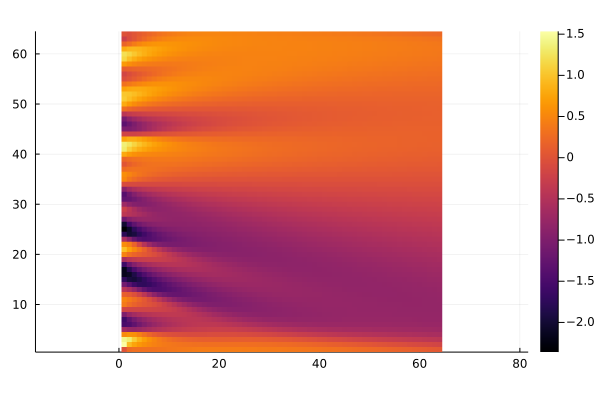

In [37]:
# check_result(K, p, 2)
t, u0, u = Generator.get_burgers_batch(1., t_min, x_max, x_min, t_n, x_n, 0.04, 2);
prob_neuralode = DiffEqFlux.NeuralODE(K, (t[1], t[end]), Tsit5(), saveat=t)
u_pred = prob_neuralode(u0, p) # add_dim(u0)
GraphicTools.show_state(u, "")

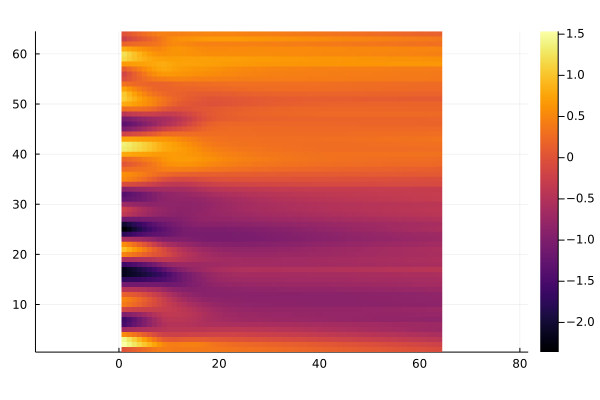

In [38]:
GraphicTools.show_state(hcat(u_pred.u...), "") # [:, :, 1, 1]

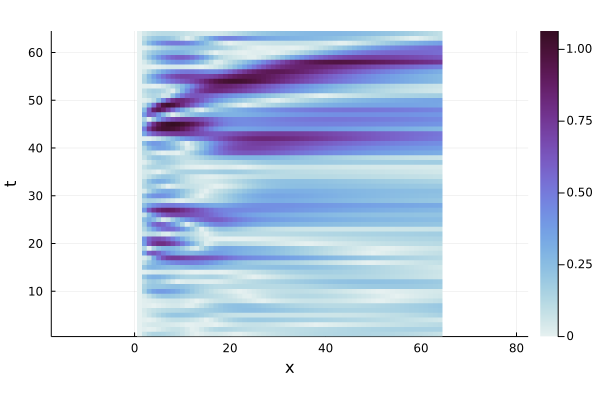

In [35]:
GraphicTools.show_err(hcat(u_pred.u...)[:, :, 1, 1], u, "")

In [ ]:
data = Generator.read_dataset("./src/examples/burgers/dataset/burgers_high_dim_training_set.jld2")["training_set"];
t, u0, u = ProcessingTools.process_dataset(data, false);
prob_neuralode = DiffEqFlux.NeuralODE(K, (t[1], t[end]), Rosenbrock23(), saveat=t);
i = 43
u_pred = prob_neuralode(u0[:, i], p);
display(
    plot(
        GraphicTools.show_state(u[:, i, :], ""),
        GraphicTools.show_state(hcat(u_pred.u...), ""),
        GraphicTools.show_err(hcat(u_pred.u...), u[:, i, :], "");
        layout = (1, 3),
    )
)